In [1]:
import numpy as np 
import obspy as obs
from obspy.clients.fdsn.client import Client
from obspy.geodetics.base import gps2dist_azimuth, kilometers2degrees
from scipy.signal import butter, filtfilt
import matplotlib.pylab as pl
from obspy.core.utcdatetime import UTCDateTime
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import fastparquet
import scipy.signal as sp
import functions 
from obspy.taup import plot_travel_times,TauPyModel
from obspy.taup.tau import plot_ray_paths
from obspy.clients.iris import Client as Client_dist
import pandas as pd
import os
from obspy import read
import obspy.signal as sig
from matplotlib.animation import FuncAnimation



%matplotlib ipympl

# Retrieving the metadata from the earthquake

In [2]:
client = Client('IRIS')
eventtime = UTCDateTime('2010-02-27 06:34:11')

eq_list = client.get_events(
    minmagnitude=8.5,
    starttime=eventtime-10,
    endtime=eventtime+10)


for event in eq_list.events:
    for origin in event.origins:
        eq_time = origin.time
        eq_depth = origin.depth
        eq_lat = origin.latitude
        eq_lon  = origin.longitude
        
        
for event in eq_list.events:
    for magnitude in event.magnitudes:
        eq_mag = magnitude.mag

print(eq_time)
print(eq_mag)
print(eq_depth)

2010-02-27T06:34:13.330000Z
8.8
28100.0


# Looking for stations around the eq and downloading the associated traces for few minutes only 

In [3]:
#RECHERCHE DE TRACES BROADBAND VENANT DE TOUS LES ARRAYS  AUTOUR DE L'EQ !!  CETTE CELLULE SERT À LES RÉCUP, PAS ENCORE À PLOT!
compute_distance = Client_dist() #on utilise un outil qui calculera la distance angulaire qui est  nécessaire pour obspy pour calculer le travel time 
# plt.close('all')

# #parameters
# channels = 'BHZ,HHZ,EHZ,SHZ'

# #on commence par établir une liste de stations respectant nos critères, et on rajoute alors 
# station_list = client.get_stations(network='TA',station='*',location='*',channel=channels, starttime=eventtime-1, endtime=eventtime+1, 
#                                 level='station') #  latitude=eq_lat , longitude=eq_lon, maxradius=max_radius, minradius=min_radius


# try:
#     df = pd.load_csv('stations_TA.csv')
# except:
#     data = []

# for net in station_list:
#     for sta in net:        
#         network = net.code
#         station = sta.code
#         latitude = sta.latitude
#         longitude = sta.longitude
#         info = compute_distance.distaz(eq_lat, eq_lon, latitude, longitude)
#         distance = info['distance']
#         azimuth = info['azimuth']
#         ## saving 
#         data.append({"Network": network, "Station": station, "Latitude": latitude, "Longitude": longitude, "Distance": distance, "Azimuth": azimuth})
#         df = pd.DataFrame(data)
#         df.to_csv('stations_TA.csv')

# print(f"{len(df['Distance'].values)} stations to download from")  


In [4]:
pd.read_csv('stations_TA.csv')

,Unnamed: 0,Network,Station,Latitude,Longitude,Distance,Azimuth
0,0,TA,034A,27.064699,-98.683296,67.58271,157.60460
1,1,TA,035A,26.937901,-98.102303,67.26943,158.04862
2,2,TA,035Z,26.462999,-98.068298,66.81853,158.00070
3,3,TA,109C,32.888901,-117.105103,80.35951,145.05910
4,4,TA,113A,32.768299,-113.766701,78.69167,147.29046
...,...,...,...,...,...,...,...
412,412,TA,Z31A,33.318298,-100.143501,73.83421,157.29848
413,413,TA,Z32A,33.306599,-99.478302,73.61034,157.81334
414,414,TA,Z33A,33.286499,-98.764801,73.36831,158.36769
415,415,TA,Z34A,33.371201,-97.915802,73.18848,159.04304


## Now we know the stations, so we download their traces

In [9]:
data = pd.read_csv('stations_TA.csv')
network_list_clean = list(data['Network'].values)
station_list_clean = list(data['Station'].values)
latitudes_list_clean = list(data['Latitude'].values)
longitudes_list_clean = list(data['Longitude'].values)
distances_list_clean = list(data['Distance'].values)
azimuth_list_clean  = list(data['Azimuth'].values)
channels = 'BHZ,HHZ,EHZ,SHZ'

################### TÉLÉCHARGEMENT DES TRACES ET ON LES RASSEMBLE DANS DES LISTES POUR POUVOIR TOUT PLOT AVEC LES COULEURS À LA FIN WAOUW 
start_delay = -30
duration = 1800
pad = 20 #télécharger pad secondes avant et après la trace pour s'assurer que elle soit pas affectée par effet de bord 
output_type = 'VEL'
starttime_obspy = eq_time+start_delay-pad 
endtime_obspy = eq_time+start_delay+duration+pad

bad_station_indexes = []

for i in tqdm(range(len(station_list_clean))):
    if os.path.exists(f'/media/parisnic/STOCKAGE/traces/{station_list_clean[i]}.mseed')==False: 
    # if os.path.exists(f'/home/parisnic/traces/{station_list_clean[i]}.mseed')==False:    
        try:
            st = client.get_waveforms(network=network_list_clean[i], station=station_list_clean[i], location='*', channel=channels, attach_response=True,
                                              starttime=starttime_obspy,endtime=endtime_obspy)
            st.remove_response(output=output_type)
            st.detrend('demean')            
            tr = st[0]
            tr.write(f"/media/parisnic/STOCKAGE/traces/{station_list_clean[i]}.mseed", format="MSEED")
            # tr.write(f"/home/parisnic/traces/{station_list_clean[i]}.mseed", format="MSEED")
        except:
            bad_station_indexes.append(i)
    
    
try:
    for bad_index in bad_station_indexes:
        print(f'{network_list_clean[bad_index]}.{station_list_clean[bad_index]} could not be downloaded')
except:
    print('All stations were downloaded correctly! yey')
                
for bad_index in sorted(bad_station_indexes, reverse=True):#c'est l'heure de supprimer les mauvaises stations de la liste 
    network_list_clean.pop(bad_index) #on supprime la station de la liste pour avoir une liste mise à jour!
    station_list_clean.pop(bad_index)
    latitudes_list_clean.pop(bad_index)
    longitudes_list_clean.pop(bad_index)
    distances_list_clean.pop(bad_index)
    azimuth_list_clean.pop(bad_index)

    
#on exporte alors un fichier qui va rassembler les informations sur les stations, ce fichier sera alors directement utilisé pour le grid search! faudra pas contre use des try
#pour éviter que ça plante si une station est pas accessible! 

# output = pd.DataFrame(list(zip(network_list_clean, station_list_clean, latitudes_list_clean, longitudes_list_clean, fs_list_clean)), columns=['net','sta','lat','lon','fs'])
# output.to_csv(f'stations_{eq}_grid_search.csv')

100%|████████████████████████████████████████| 417/417 [00:02<00:00, 158.75it/s]

TA.MDND could not be downloaded
TA.Y12C could not be downloaded


In [10]:
#on fait à présent un tableau avec les traces, on resample les traces si besoin et on les filtres si l'on souhaite
time_list = []
arr_list = []
color_list = []
fs_list_clean = []

##### parameters to resmaple####
fs = 40 #frequency at which we will resample all the traces 

##### parameters to remove the padding and  we can also change the parameters to only keep a specific part of the traces ######
start_delay = 500 
duration = 1200

filtered = 'bandpass'
freq = [1,5]
order = 2 #order du filtre  -> filtfilt donc sera doublé!

for i in range(len(station_list_clean)): #on a supprimé les mauvaises stations et téléchargé les traces, avec le minimum de processing possible pour les garder en 
    #bon état
    st = read(f'/media/parisnic/STOCKAGE/traces/{station_list_clean[i]}.mseed')
    # st = read(f'/home/parisnic/traces/{station_list_clean[i]}.mseed')

    if st[0].stats.sampling_rate>fs: #on resample si trop hf 
                st.resample(fs, window='hann', no_filter=True, strict_length=False)

    tr = st[0]
    fs_list_clean.append(tr.stats.sampling_rate)
            
    if filtered!=None:
        st.filter(filtered,freqmin=freq[0],freqmax=freq[1],corners=order,zerophase=True) #fs_list_clean[i],
            
#     if filtered=='bandpass':
#         b,a = butter(order, [freq[0],freq[1]], btype='bandpass', output='ba', fs=fs_list_clean[i])
#         arr = filtfilt(b,a,arr)

#     elif filtered=='highpass':
#         b,a = butter(order, freq, btype='highpass', output='ba', fs=fs_list_clean[i])
#         arr = filtfilt(b,a,arr)
        
    arr = tr.data
    time_arr = (tr.times(reftime=eq_time)) #on doit à présent chercher dans time_arr où se trouve     
    indexes_to_keep = np.where((time_arr>=start_delay) & (time_arr<=start_delay+duration))
    time_arr = time_arr[indexes_to_keep]
    arr = arr[indexes_to_keep]
    arr_list.append(list(arr))
    time_list.append(list(time_arr))
    color_list.append(int(azimuth_list_clean[i]))

In [11]:
# # ici on vérifie rapidement des spectrogrames histoire de voir la gamme de fréquence à conserver afin de conserver plutôt la P
# #sinon on peut juste mute les autres arrivées en se basant sur loi de vitesse en focntion de la distance
# plt.close('all')

# trace_number = 2
# order = 2
# freq = 2

# b,a = butter(order, freq, btype='highpass', output='ba', fs=fs_list_clean[trace_number])
# arr = arr_list[trace_number]
# arr = filtfilt(b,a,arr)

# plt.figure()
# plt.plot(time_list[trace_number], arr)


# f, t, Z = sp.stft(arr, fs=fs_list_clean[trace_number], window='hann', nperseg=100, noverlap=50, nfft=None, 
#                             detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')

# plt.figure()
# plt.pcolormesh(t,f,np.abs(Z))

In [12]:
#it's resampled but sometimes there is an additionnal sample at some stations which is troublesome, so we remove this additionnal sample at the beginning! 

min_nt = 99999999999999999999
for time in time_list:
    if len(time) < min_nt:
        min_nt = len(time)


arr_list_good = []
time_list_good = []

for i in range(len(time_list)):
    if len(time_list[i]) != min_nt:
        time_list_good.append(time_list[i][1:])
        arr_list_good.append(arr_list[i][1:])
    else:
        time_list_good.append(time_list[i])
        arr_list_good.append(arr_list[i])



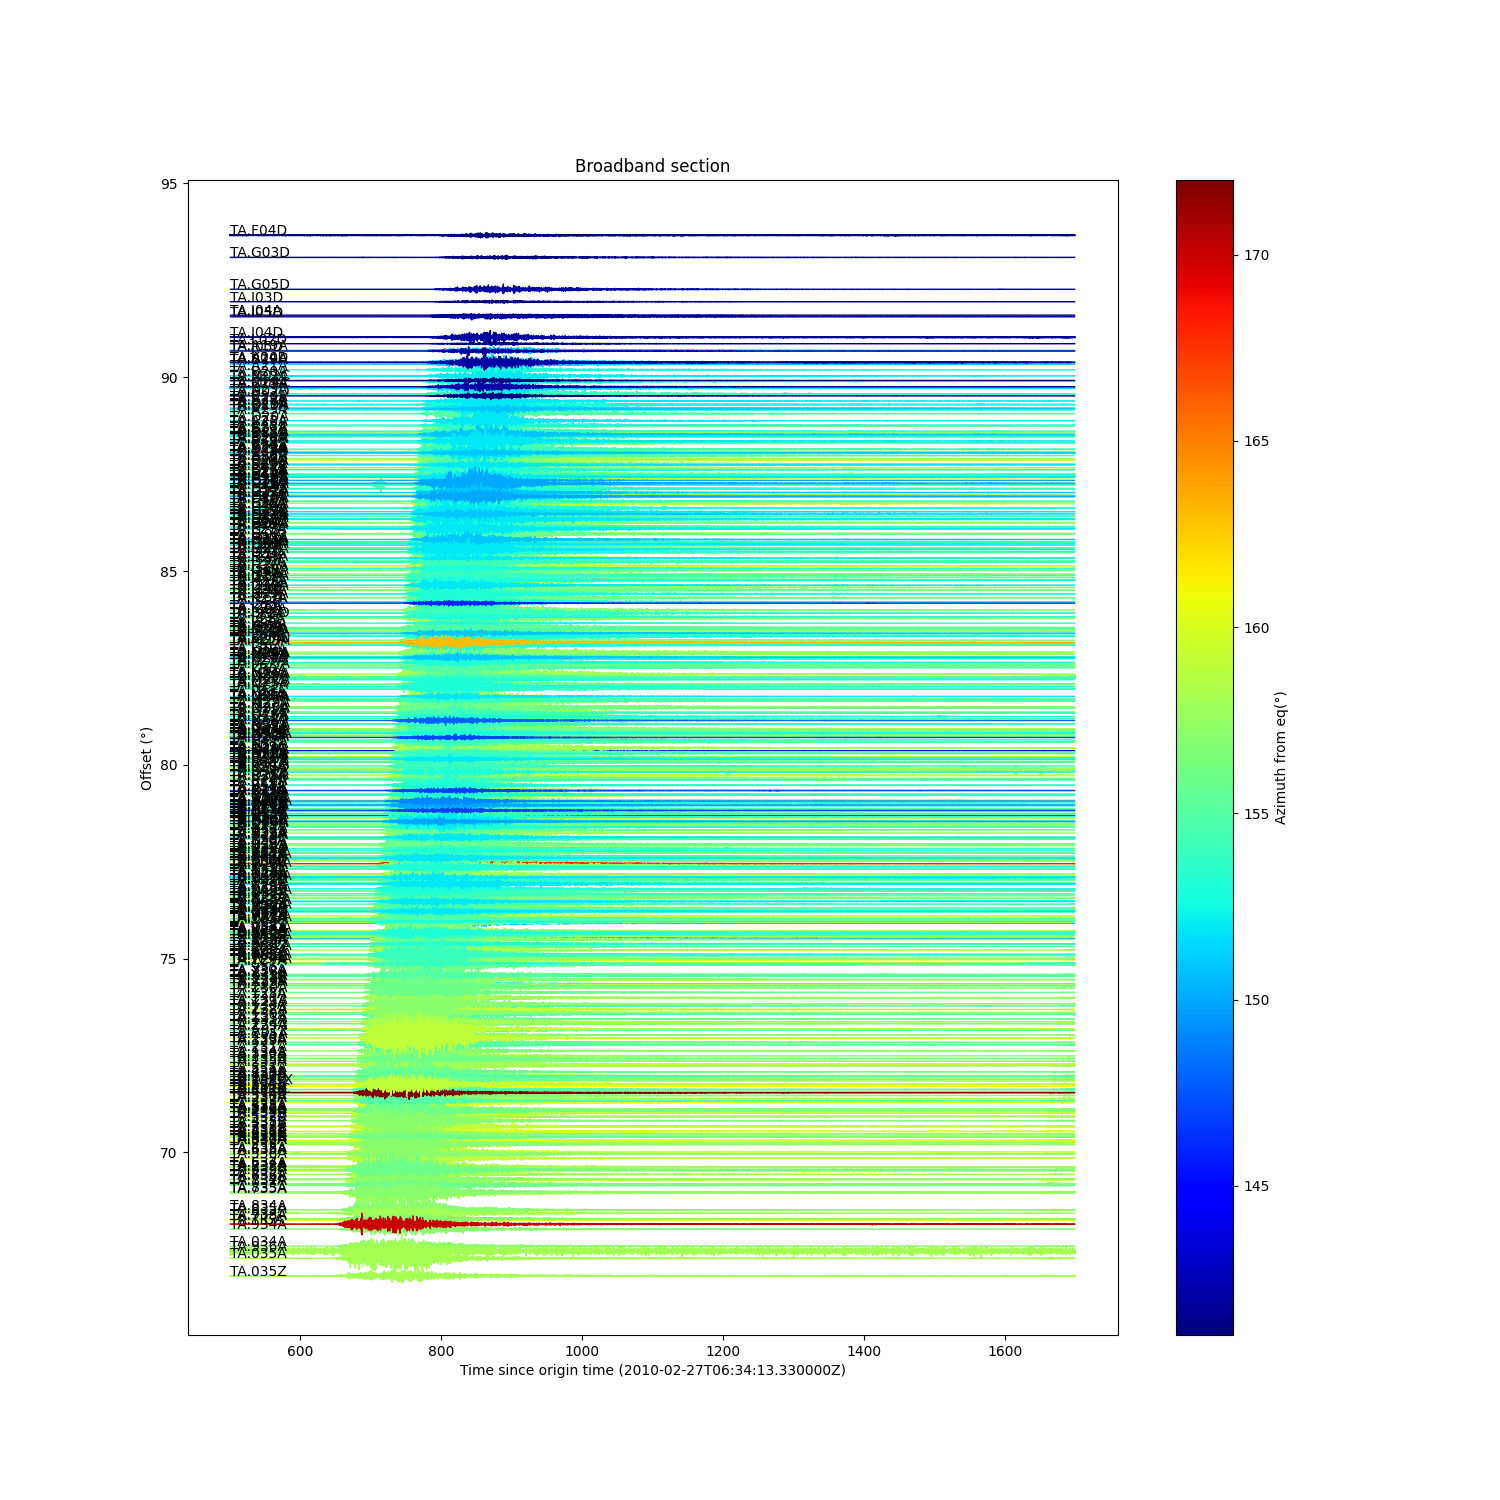

In [9]:
plt.close('all')

zoom = None #[0,60,30,45] #x0, x1, y0, y1  
scaling = 'float'

arr_list_transformed = []
for i in range(len(station_list_clean)):
    if scaling=='float':
        arr_transformed = 3e4*np.array(arr_list_good[i]) + distances_list_clean[i]    
    elif scaling =='distance': 
        arr_transformed = 5e2* 4*np.pi*(distances_list_clean[i]) * np.array(arr_list_good[i]) + distances_list_clean[i] #+ dist clean pour faire offset
    elif scaling == 'binary':
        max_amp = np.max(np.abs(np.array(arr_list_good[i])))  
        coeff = 3/max_amp
        arr_transformed = coeff*np.array(arr_list_good[i]) + distances_list_clean[i]
    else:
        arr_transformed = np.array(arr_list_good[i]) + distances_list_clean[i] #pas de scaling, donc on verra rien sans zoom   
    
    arr_list_transformed.append(arr_transformed)

fig, ax = plt.subplots(figsize=(15,15))
lc = functions.multiline(time_list_good, arr_list_transformed, color_list, cmap='jet', lw=1)
axcb = fig.colorbar(lc)
axcb.set_label('Azimuth from eq(°)')
ax.set_title('Broadband section')
ax.set_xlabel(f'Time since origin time ({eq_time})')
ax.set_ylabel('Offset (°)')

for i, distance in enumerate(distances_list_clean):
    ax.text(time_list_good[i][0],distance,f'{network_list_clean[i]}.{station_list_clean[i]}')

if zoom!=None:
    ax.set_xlim(zoom[0],zoom[1])
    ax.set_ylim(zoom[2],zoom[3])
        
# plt.savefig(f'{eq}_broadband.png', dpi=300, bbox_inches='tight')

We will now mute the later part of the signals to make sure we don't get other waves or noise

In [13]:
#muting the later parts of the signals 

# print(len(arr_list_good[0]))
# np.array(arr_list_good)


# We now have traces ready to be used for the inversion process

In [14]:
# model = TauPyModel(model='iasp91')
# print( model.get_ray_paths(source_depth_in_km=eq_depth/1000, distance_in_degree=distances_list_clean[0], phase_list=['P'])[0].time) 


## version avec rms sur full duration

In [15]:
# Create a grid of potential sources : we use lat lon coordinates intead of cartesian coordinates for the gridsearch to make it easier
x    = np.linspace(-74,-70, 25)
y    = np.linspace(-38, -33, 25)
x, y = np.meshgrid(x, y)

# Depth of the source (assumed to be known)
z = eq_depth/1000 #converted to km 

# Initialize the RMS for each potential source
rms = np.zeros((x.shape[0], x.shape[1]))

# Initialize the stacks for each potential source
obs = np.array(arr_list_good) #normalement devrait avoir taille  nr, nt 
nt = len(obs[0,:]) #number of samples : should be the same for all traces since we decimated them
stacks = np.zeros((nt, x.shape[0], x.shape[1]))

#on utilise le ray tracing 1D d'obspy pour estimerle travel time entre la source et chacune des stations 
model = TauPyModel(model='iasp91')


#just need to compute the time with 1D raytracing with obspy ()
for i in tqdm(range(x.shape[0]),leave=False): #looping over potential sources  
    for j in range(x.shape[1]):
        dist = np.zeros(len(distances_list_clean))
        ttime = np.zeros_like(dist)
        for k in range(len(longitudes_list_clean)): # looping over receivers and computing their distance to the potnetial source location which is important to  shift the traces accordingly 
            dist_km = gps2dist_azimuth(latitudes_list_clean[k],longitudes_list_clean[k],y[i,j],x[i,j])[0]/1000
            dist[k] = kilometers2degrees(dist_km) #  computing the distance between a potential source and the receivers 
            ttime[k] = model.get_ray_paths(source_depth_in_km=eq_depth/1000, distance_in_degree=dist[k], phase_list=['P'])[0].time
        obs_shifted = functions.shift(obs, ttime, fs_list_clean)
        stacks[:,i,j] = np.sum(obs_shifted,axis=0)
        rms[i,j]  = np.sqrt(np.sum((stacks[:,i,j])**2)) 


                                                                                
KeyboardInterrupt



In [109]:
# plt.figure()
# plt.plot(stacks[:,0,0])
# plt.plot(arr_list_good[0])


TypeError: Dimensions of C (140, 20, 20) should be one smaller than X(20) and Y(20) while using shading='flat' see help(pcolormesh)

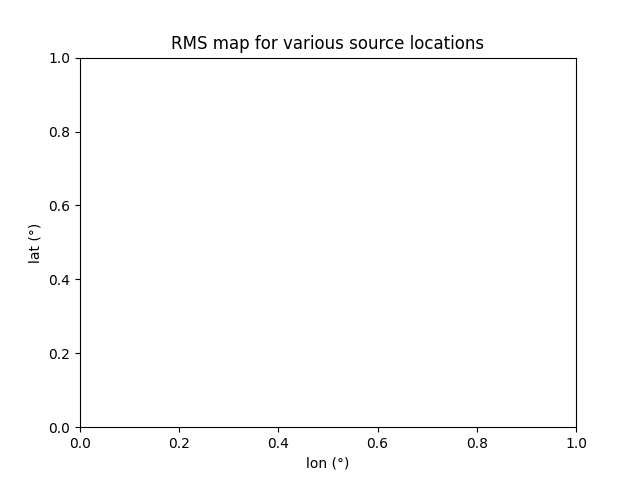

In [2]:
#on plot à présent la rms matrix pour voir si on a bien un alignement de forte amplitude 

run_folder = 'run_time2'

rms = np.load(f'{run_folder}/rms.npy')
x, y = np.load(f'{run_folder}/x.npy'), np.load(f'{run_folder}/y.npy') 


plt.figure()
plt.title('RMS map for various source locations')
plt.xlabel('lon (°)')
plt.ylabel('lat (°)')
plt.pcolormesh(x,y,rms)
# bon on voit que c'est pas fou mais on va quand même essayer de voir ... 

In [3]:
#maintenant à chaque pas de temps on cherche où l'énergie est la plus forte 
stacks = np.load(f'{run_folder}/stacks.npy')

nt = len(stacks[:,0,0])

# Initialize a time vector for locations and stack amplitude
xx = np.zeros(nt)
yy = np.zeros(nt)
zz = np.zeros(nt)

#à cherche à présent dans matrice de stack pour chaque time step à quelle position l'énergie est la plus forte -> on trouve alors la position de la source à chaque pas de temps 
#il nous  faut donc une matrice de taille (length signal, 2 ) histoire de pouvoir store x et y 

for i in range(nt):
    idx = np.unravel_index(np.argmax(np.abs(stacks[i,:,:]), axis=None), stacks[i,:,:].shape)
    xx[i] = x[0,idx[0]] #on lui donne des coordonnées au lieu des indices 
    yy[i] = y[idx[1],0]
    zz[i] = stacks[i,idx[0],idx[1]] #zz est l'maplitude associée au point de coordonnées x et y qui a la plus forte amplitude dans le stack à temps i 


FileNotFoundError: [Errno 2] No such file or directory: 'run_good/stacks.npy'

In [5]:
max_amplitude_total = np.max(np.abs(stacks))
time_mod = np.load(f'{run_folder}/time.npy')


xx_select = []
yy_select = []
time_select = []

for i in range(nt): #on boucle encore sur les pas de temps et on vérifie si les amplitudes sont supérieures au threshold fourni 
    if np.abs(zz[i])>0.8*max_amplitude_total: 
        xx_select.append(xx[i])
        yy_select.append(yy[i])
        time_select.append(time_mod[i])
        
xx_select = np.array(xx_select)
yy_select = np.array(yy_select)
time_select = np.array(time_select)

plt.figure()
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Time evolution of the source location')
plt.scatter(xx_select,yy_select,c=time_select,cmap='jet')

NameError: name 'time_list_good' is not defined

The rupture velocity is  -0.6624076988853693 km/s.


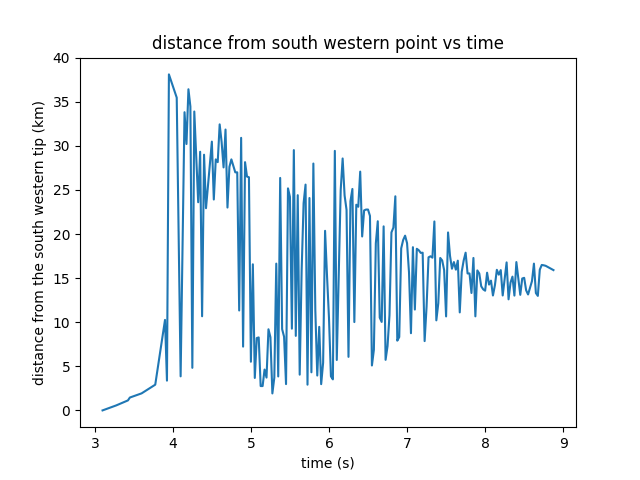

In [36]:
#calcule les distances par rapport à la première position xx et yy selectionnés; car le premier selectionné est à la position où le séisme a eu lieu
distances = np.zeros(len(xx_select))
for i in range(len(distances)):
    distances[i] = gps2dist_azimuth(yy_select[i],xx_select[i],yy_select[0],xx_select[0])[0]/1000 
# print(distances)


#calcul des distances intersources sélectionnées pour pouvoir calculer des vitesses locales le long de la faille !!
short_distances = distances[1:]-distances[:-1] #difference between the distance of neighbour points = short distances 
short_times = time_select[1:]-time_select[:-1]


plt.figure()
plt.title('distance from south western point vs time')
plt.xlabel('time (s)')
plt.ylabel('distance from the center (km)')
plt.plot(time_select,distances) #slope is the velocity

#on a une évolution linéaire de la distance avec le temps, donc vitesse constante et on peut calculer la vitesse avec un polyfit pour avoir la slpe :
print('The rupture velocity is ', np.polyfit(time_select,distances,1)[0], 'km/s.')


# Version avec RMS sur fenêtres de temps

cf script make_run_window.py

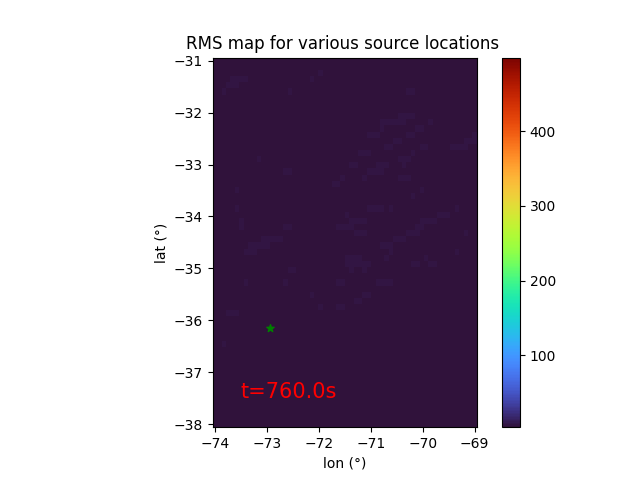

In [14]:
plt.close('all')
run_folder = 'run_plage20_cross10_hd'

rms = np.load(f'{run_folder}/rms.npy')
x, y = np.load(f'{run_folder}/x.npy'), np.load(f'{run_folder}/y.npy') 
times = np.load(f'{run_folder}/times.npy')


times_fig = np.mean(times, axis = 1)

fig, ax = plt.subplots()
ax.set_title('RMS map for various source locations ')
ax.set_xlabel('lon (°)')
ax.set_ylabel('lat (°)')
ax.set_aspect('equal')  # Make sure the aspect ratio is equal

# Initialize pcolormesh
im = ax.pcolormesh(x,y,rms[0,:,:], cmap='turbo',vmin=np.min(rms),vmax=np.max(rms))
text_annotation = ax.text(-73.5,-37.5,f't={times_fig[0]}s',color='red', fontsize=15)
ax.scatter(eq_lon, eq_lat, marker='*', s=30, color='green')
fig.colorbar(im, ax=ax)


# Function to update the pcolormesh for each time step
def update(frame):
    text_annotation.set_text(f't={times_fig[frame]}s')
    im.set_array(rms[frame,:,:].ravel())
    
# Create an animation
ani = FuncAnimation(fig, update, frames=len(times_fig), repeat=False)

# Save the animation as an MP4 video
ani.save(f'{run_folder}/animation_pcolormesh.mp4', writer='ffmpeg')

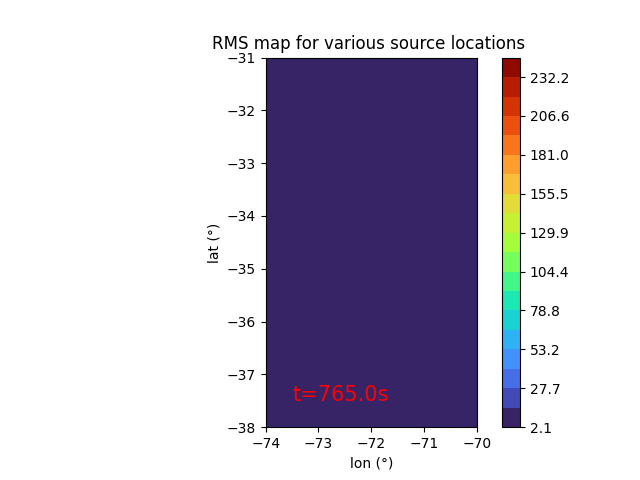

In [5]:
run_folder = 'run_time_cross'

rms = np.load(f'{run_folder}/rms.npy')
x, y = np.load(f'{run_folder}/x.npy'), np.load(f'{run_folder}/y.npy') 
times = np.load(f'{run_folder}/times.npy')


times_fig = np.mean(times, axis = 1)

fig, ax = plt.subplots()
ax.set_title('RMS map for various source locations ')
ax.set_xlabel('lon (°)')
ax.set_ylabel('lat (°)')
ax.set_aspect('equal')  # Make sure the aspect ratio is equal

# Initialize pcolormesh
contours = ax.contourf(x,y,rms[0,:,:], cmap='turbo',levels=np.linspace(np.min(rms), np.max(rms), 20))
ax.scatter(eq_lon, eq_lat, marker='*', s=30, color='green')
text_annotation = ax.text(-73.5,-37.5,f't={times_fig[0]}s',color='red', fontsize=15)
fig.colorbar(contours, ax=ax)


# Function to update the pcolormesh for each time step
def update(frame):
    global contours
    text_annotation.set_text(f't={times_fig[frame]}s')
    # Update the pcolormesh with the data at the current time step
    contours.collections.clear()  # Clear the old contour collections
    contours = ax.contourf(x, y, rms[frame, :, :], cmap='turbo', levels=np.linspace(np.min(rms), np.max(rms), 20))
    
# Create an animation
ani = FuncAnimation(fig, update, frames=len(times_fig), repeat=False)

# Save the animation as an MP4 video
ani.save(f'{run_folder}/animation_contourf.mp4', writer='ffmpeg')

On calcule la vitesse à partir des maps de RMS que l'on a modélisé : pour ça il nous suffit sur chaque map de RMS de trouver le maximum d'amplitude, de calculer sa 
diistance par rapport à la première position (celle du temps 0 ) pour les différents temps (temps considéré sera moyenne entre le temps du début et de la fin de la fenêtre) -> notre premier pas de temps devrait correspondre au temps 0 de l'eq ? donc la première image devrait être le temps 0 de l'eq  ->  première image c'est bien le temps 0 de l'eq  -> on peut donc 

Text(0.05, 0.9, 'v=3.0 km/s')

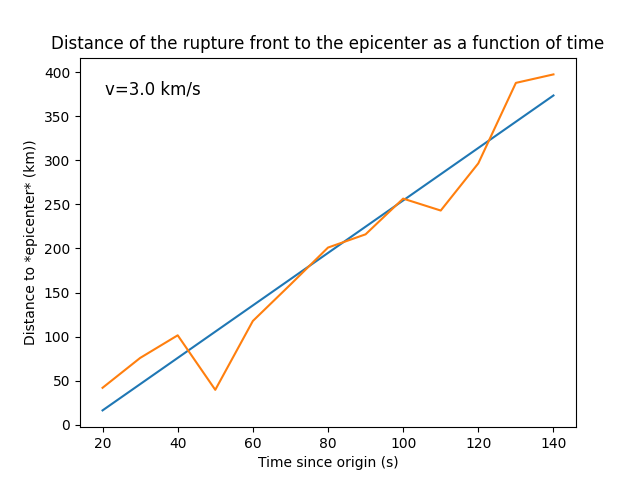

In [17]:
#calcul de la vitesse car on a sauvegardé le temps de chaque image et on peut s'en servir pour calculer la vitesse de propagation 

#looping over rms maps to know where the amplitude is the highest -> pour l'instant marchera pas des masses car il trouve un blob sur le côté ... 
xx = np.zeros(len(times_fig))
yy = np.zeros(len(times_fig))
zz = np.zeros(len(times_fig))
distances = np.zeros(len(times_fig))

for i in range(len(times_fig)):
    idx = np.unravel_index(np.argmax(np.abs(rms[i,:,:]), axis=None), rms[i,:,:].shape)
    xx[i] = x[0,idx[0]] #on lui donne des coordonnées au lieu des indices 
    yy[i] = y[idx[1],0]
    zz[i] = rms[i,idx[0],idx[1]]    
    distances[i] = gps2dist_azimuth(yy[i],xx[i],eq_lat,eq_lon)[0]/1000 #calcul distance par rapport à première position e, kliomètres 
    

### we only select idexes where the rms is larger than 50% of the max rms in zz 
selected_idx = np.where(zz>=0.5*np.max(zz))[0]
# selected_idx = np.append(0,selected_idx) #rajoute le 0 au cas ou 


weights = np.ones(len(times_fig[selected_idx]))
# weights[0] = 99999999 #to make sure the fit passes through the 0!
fit = np.polyfit(times_fig[selected_idx],distances[selected_idx],1,w=weights )


fig, ax = plt.subplots()
ax.set_title('Distance of the rupture front to the epicenter as a function of time')
ax.set_ylabel('Distance to *epicenter* (km))')
ax.set_xlabel('Time since origin (s)')
ax.plot(times_fig[selected_idx], np.polyval(fit,times_fig[selected_idx]))
ax.plot(times_fig[selected_idx],distances[selected_idx])
ax.text(0.05,0.9, f'v={round(fit[0],1)} km/s', fontsize=12, transform=ax.transAxes)


#il faut qu'on force le polyfit  #on a maintenant une vitesse moyenne de 2.6 km/s !! 


[]

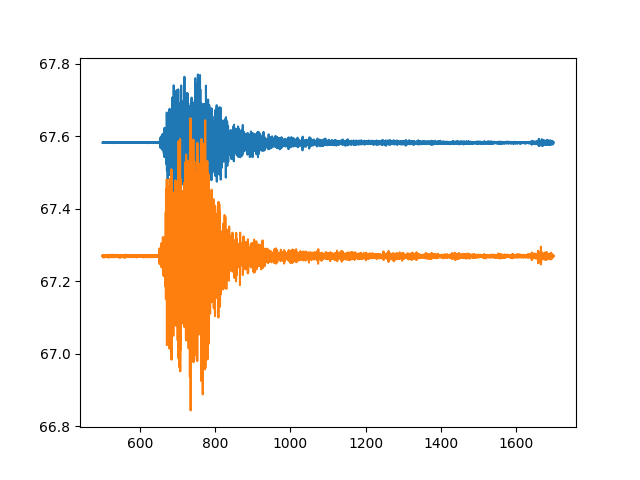

In [14]:
plt.figure()
plt.plot(time_list_good[0],arr_list_transformed[0])
plt.plot(time_list_good[1],arr_list_transformed[1])
plt.plot()




In [20]:
tr1 = functions.normalize_trace(arr_list_good[0])
tr2 = functions.normalize_trace(arr_list_good[1])

model = TauPyModel(model='iasp91')
ttime1 = model.get_ray_paths(source_depth_in_km=eq_depth/1000, distance_in_degree=distances_list_clean[0], phase_list=['P'])[0].time
ttime2 = model.get_ray_paths(source_depth_in_km=eq_depth/1000, distance_in_degree=distances_list_clean[1], phase_list=['P'])[0].time

delta_static = 30 #30s de répit devant 

n_shift1 = int((ttime1-start_delay-delta_static)*fs)
n_shift2 = int((ttime2-start_delay-delta_static)*fs)

tr1 = functions.shift(tr1, n_shift1)
tr2 = functions.shift(tr2, n_shift2)

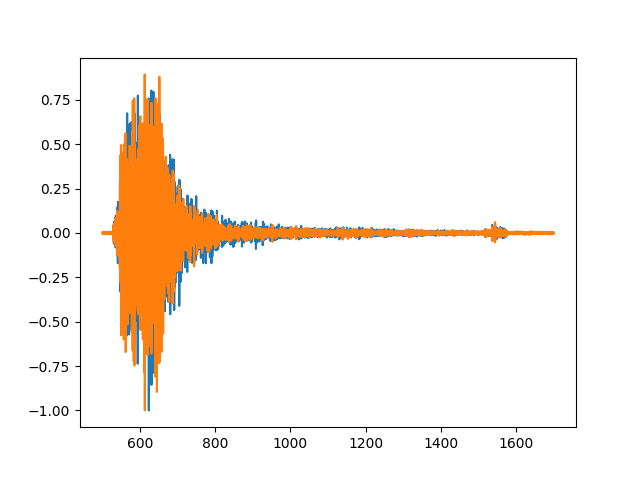

In [21]:
plt.figure()
plt.plot(time_list_good[0],tr1)
plt.plot(time_list_good[1],tr2)


-2


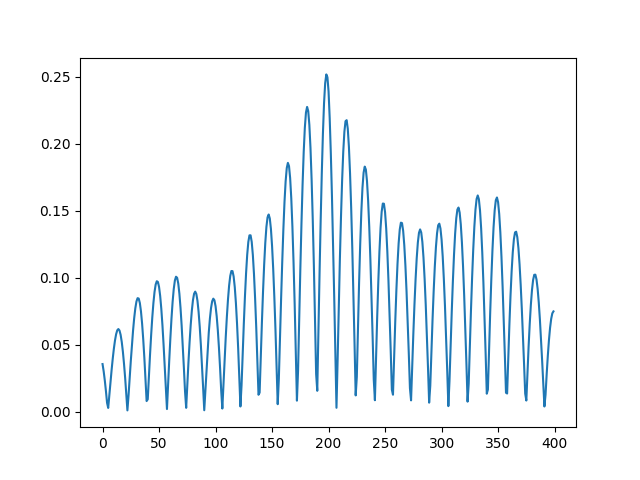

In [34]:
#c'est l'heure de cross corréler 

r = fs*5
#on soustrait un peu car j'ai l'imrpession que on surestime le travel time  du coup on commence trop tard à regarder la cohérence 


corr = np.correlate(tr1[delta_static*fs-r:(delta_static+10)*fs-r],tr2[delta_static*fs-r:(delta_static+10)*fs-r], mode='same')


nt = np.argmax(np.abs(corr))-len(corr)//2  #donne le nombre d'chantillon à décaller 


print(nt)



#on veut seulement cross corréler les première secondes -> on veut donc cross corréler trace[delta_static*fs: ... ] mais faut pouvoir prendre un peu avant 




plt.figure()
plt.plot(np.abs(corr))

In [39]:
tr2_shifted = functions.shift(tr2,nt)

In [40]:
print(np.sqrt(np.sum( (tr1[delta_static*fs-r:(delta_static+10)*fs-r] - tr2[delta_static*fs-r:(delta_static+10)*fs-r])**2 ) ))
print(np.sqrt(np.sum( (tr1[delta_static*fs-r:(delta_static+10)*fs-r] - tr2_shifted[delta_static*fs-r:(delta_static+10)*fs-r])**2 ) ))

0.4306612349689963
0.5266699842061063


In [35]:
run_folder = 'run_plage30_cross4'

n_corr = np.load(f'{run_folder}/n_corr.npy')
polarity = np.load(f'{run_folder}/polarity.npy')
print(n_corr)

# print(polarity)

[  0.  16.  54.  25.  18.   9.  31.  56.  26.  72.  61.  56.  -1.  72.
  32.  10.  31.  21.  59.  40.  72.  62.  25.  56.  51.  66.  19.  -5.
  49.  47.  61.  58.   6.  16.  11.  46.   7.  -6.  12.  19.  22.  26.
  -1.  64.  39.  51.  24.  16.  26.  20.   4.  11.  37.   3.  23.  65.
  10.  20.   2.  24.   0.  21.   1.  51. -11.  12.  46.  38.  20.  14.
 -21.  25.  13.   7. -10.   7. -18.  12. -34. -33. -25. -48. -23. -20.
   9. -35. -26. -33.  64. -42.  41. -38. -38. -44. -34.   6.  67.  65.
  67. -24.  71.  54.  64.  68. -21. -30. -35.  64. -31.  53. -26.  61.
  37. -27.  43. -21.  58.  57. -18.  55.  11.  48.  41.  70.  39.  51.
  43. -28.  72.  51. -33.  71.  38.  38.  52. -21.  45.  35.   5. -15.
  21. -41. -33.  42.  63.  56.  48.  49.  70.  42.  57. -53.  63. -11.
 -38.  59. -41. -42.  51.  64. -20.  77.  65.  58.  43. -35.  65.  66.
  60. -37.  45.  49.  36. -10.   2.  72.  72.  58.  64.  46.  45.   8.
  16.  58.  52.  73. -36.  60.  45.  62.  60.  56.  55.  67.  32.  17.
  56. 

160
9


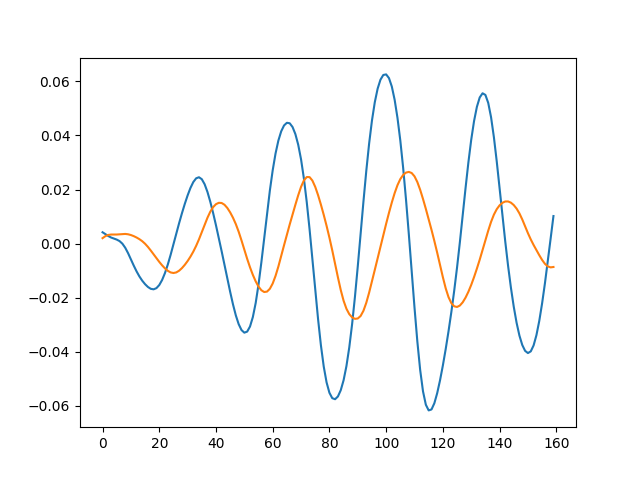

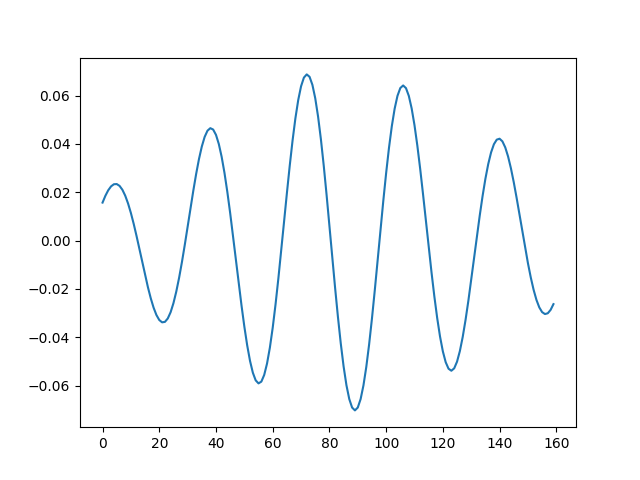

In [34]:
tr1 = functions.normalize_trace(arr_list_good[0])

tr2_idx = 5
tr2 = functions.normalize_trace(arr_list_good[tr2_idx])


model = TauPyModel(model='iasp91')
ttime1 = model.get_ray_paths(source_depth_in_km=eq_depth/1000, distance_in_degree=distances_list_clean[0], phase_list=['P'])[0].time
ttime2 = model.get_ray_paths(source_depth_in_km=eq_depth/1000, distance_in_degree=distances_list_clean[tr2_idx], phase_list=['P'])[0].time

delta_static = 30 #30s de répit devant 

n_shift1 = int((ttime1-start_delay-delta_static)*fs)
n_shift2 = int((ttime2-start_delay-delta_static)*fs)

tr1 = functions.shift(tr1, n_shift1)
tr2 = functions.shift(tr2, n_shift2)

cross_duration = 4
cross_anticipation = cross_duration//2

corr_pos = np.correlate(tr1[(delta_static-cross_anticipation)*fs:(delta_static-cross_anticipation+cross_duration)*fs],
                    tr2[(delta_static-cross_anticipation)*fs:(delta_static-cross_anticipation+cross_duration)*fs], mode='same') 

print(len(tr1[(delta_static-cross_anticipation)*fs:(delta_static-cross_anticipation+cross_duration)*fs]))

plt.figure()
plt.plot(tr1[(delta_static-cross_anticipation)*fs:(delta_static-cross_anticipation+cross_duration)*fs])
plt.plot(tr2[(delta_static-cross_anticipation)*fs:(delta_static-cross_anticipation+cross_duration)*fs])

plt.figure()
plt.plot(corr_pos)

print(np.argmax(np.abs(corr_pos))-len(corr_pos)//2) #en gros si c'est au milieu de la corr le shift est nul, et donc on shift de la pos - longueur de corr /2 
    

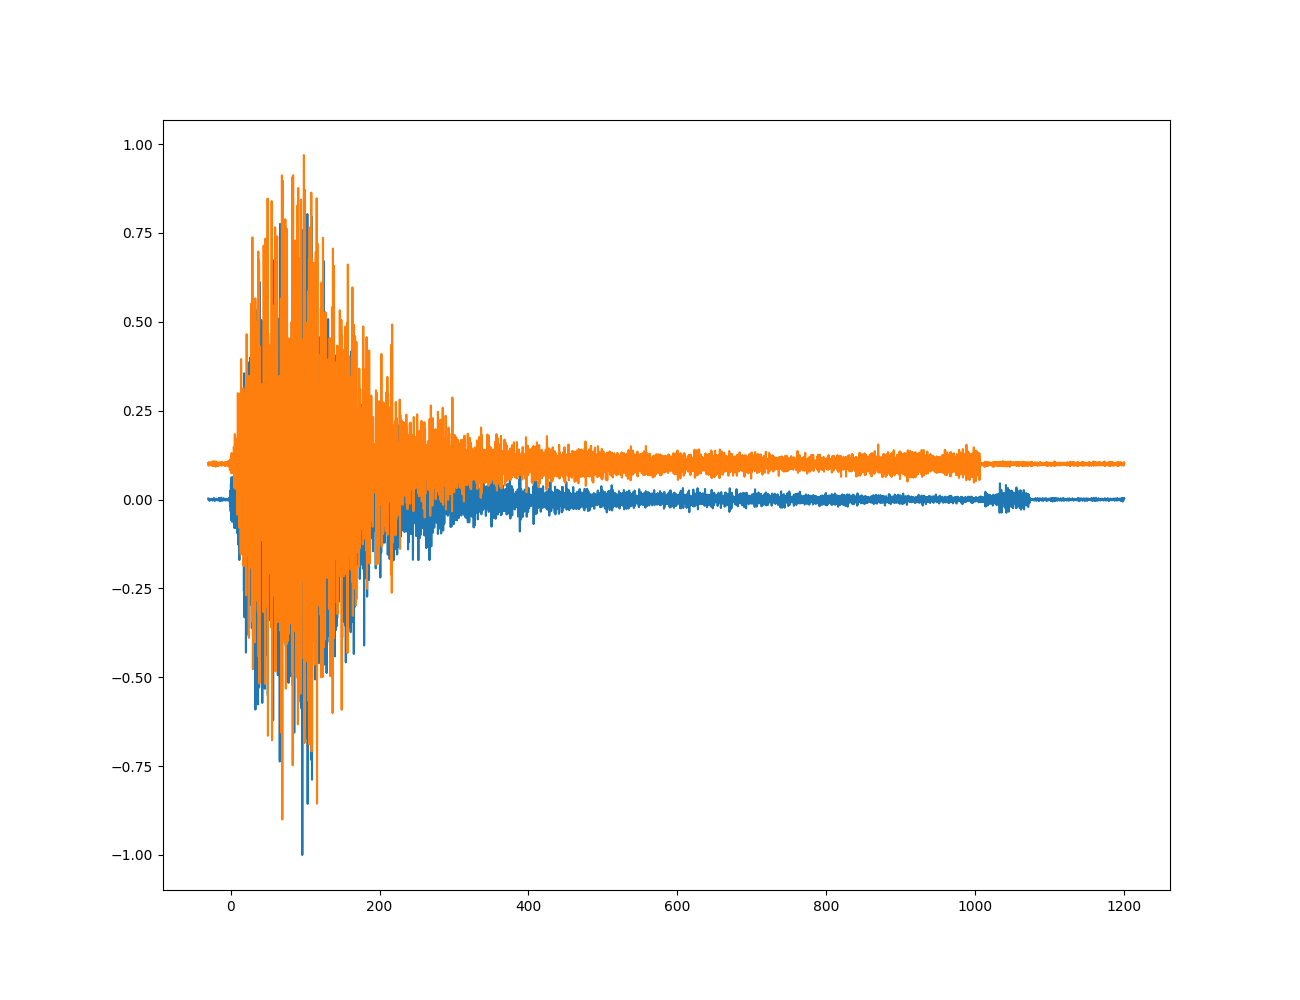

In [30]:
plt.close('all')
plt.figure(figsize=(13,10))
plt.plot(np.linspace(-30,len(tr1)*(1/fs),len(tr1)),tr1)
plt.plot(np.linspace(-30,len(tr1)*(1/fs),len(tr1)),tr2+0.1)